# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [60]:
from __future__ import print_function, division
%matplotlib inline

# Other imports
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from numpy import unravel_index
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [61]:
# Load the datasets
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')
# Show number of instances and attributes
print('Number of training instances: {}, number of training attributes: {}'.format(train_A.shape[0], train_A.shape[1]))
print('Number of validation instances: {}, number of validation attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))

Number of training instances: 2093, number of training attributes: 520
Number of validation instances: 1113, number of validation attributes: 520


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [62]:
# Display first 10 training instances
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [63]:
# Retrieve names of attributes of interest
attributes = train_A.columns[1:501].tolist()

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [64]:
# Retrieve features and targets
X_tr = train_A[attributes]
X_val = valid_A[attributes]
y_tr = train_A['is_person']
y_val = valid_A['is_person']
# Display dimensions
print(X_tr.shape)
print(X_val.shape)
print(y_tr.shape)
print(y_val.shape)

(2093, 500)
(1113, 500)
(2093L,)
(1113L,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

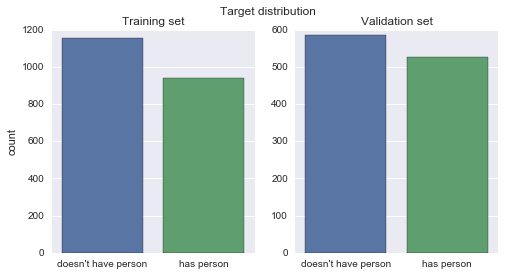

In [65]:
# Plot distribution of targets for training and validation sets
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
sns.countplot(y_tr, ax=ax1)
ax1.set_title('Training set', size=12)
ax1.set_xlabel(' ')
ax1.set_xticklabels(['doesn\'t have person','has person'])
sns.countplot(y_val, ax=ax2)
ax2.set_title('Validation set', size=12)
ax2.set_xlabel(' ')
ax2.set_ylabel('')
ax2.set_xticklabels(['doesn\'t have person','has person'])
fig.suptitle('Target distribution', size=12)
plt.show()

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

*My answer:*

A good baseline classifier would estimate every input to belong to the most common target in the training set, i.e. every image would be considered to not have a person.

In [66]:
# Calculate and print accuracy of baseline classifier
X_val_is_person_not_true = X_val[valid_A['is_person'] == False]
print("Accuracy: {0} / {1} = {2}".format(len(X_val_is_person_not_true), len(X_val), float(len(X_val_is_person_not_true))/len(X_val)))

Accuracy: 586 / 1113 = 0.526504941599


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [67]:
# Initialise logistic regressor
lr = LogisticRegression(solver='lbfgs')
# Fit and score classifier on training and validation sets
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {0}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {0}'.format(lr.score(X_val, y_val)))

Classification accuracy on training set: 0.55088389871
Classification accuracy on validation set: 0.526504941599


*Your answer goes here*

 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [68]:
# Display means and standard deviations of first 5 features in training set
np.set_printoptions(precision=3)
print("Means: {0}".format(np.array(X_tr.mean(0)[0:5])))
print("Standard deviations: {0}".format(np.array(X_tr.std(0)[0:5])))

Means: [ 0.002  0.001  0.004  0.002  0.002]
Standard deviations: [ 0.001  0.001  0.004  0.001  0.002]


### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [69]:
# Standardise training and validation features
stand_scaler = StandardScaler()
stand_scaler.fit(X_tr)
X_tr_transf = stand_scaler.transform(X_tr)
X_val_transf = stand_scaler.transform(X_val)
# Show means and standard deviations
np.set_printoptions(suppress=True)
print("Means training: {0}".format(np.array(X_tr_transf.mean(0)[0:5])))
print("Standard deviations training: {0}".format(np.array(X_tr_transf.std(0)[0:5])))
print("Means training: {0}".format(np.array(X_tr_transf.mean(0)[0:5])))
print("Standard deviations training: {0}".format(np.array(X_tr_transf.std(0)[0:5])))

Means training: [-0. -0.  0.  0. -0.]
Standard deviations training: [ 1.  1.  1.  1.  1.]
Means training: [-0. -0.  0.  0. -0.]
Standard deviations training: [ 1.  1.  1.  1.  1.]


*Your answer goes here*


### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [70]:
# Initialise logistic regressor
lr_2 = LogisticRegression(solver='lbfgs')
# Fit and score classifier on transformed training and validation sets
lr_2.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set: {0}'.format(lr_2.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set: {0}'.format(lr_2.score(X_val_transf, y_val)))

Classification accuracy on training set: 0.810797897754
Classification accuracy on validation set: 0.643306379155


*Your answer goes here*



### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [71]:
# Construct 3-fold cross-validation iterator
kf3 = KFold(len(X_tr_transf), n_folds=3, shuffle=True, random_state=0)
# Display number of test samples in each interation fold
f = 1
for train_indeces, test_indeces in kf3:
    print('Number of test samples in fold {0}: {1}'.format(f, len(test_indeces)))
    f+= 1
len(X_tr_transf)

Number of test samples in fold 1: 698
Number of test samples in fold 2: 698
Number of test samples in fold 3: 697


2093

### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [72]:
# Your code goes here
scores = np.zeros((3,20))
logs = np.logspace(-5,5,20)
f = 0
for train_indeces, test_indeces in kf3:
    log_set = 0
    for log in logs:
        lr_temp = LogisticRegression(solver='lbfgs', C=log)
        lr_temp.fit(X_tr_transf[train_indeces], y_tr[train_indeces])
        pred = lr_temp.predict(X_tr_transf[test_indeces])
        scores[f][log_set] = accuracy_score(y_tr[test_indeces], pred)
        log_set += 1
    f+= 1

### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

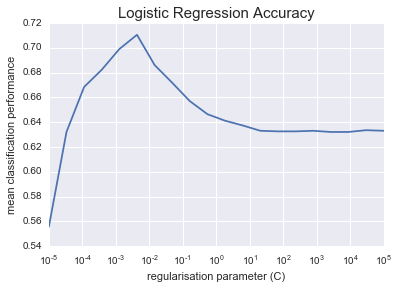

In [73]:
# Get mean scores
mean_scores = np.zeros(len(scores[0]))
for i in range(0, len(scores[0])):
    sum = 0.0
    count = 0
    for fold_scores in scores:
        sum += fold_scores[i]
        count += 1
    mean_scores[i] = sum/count
# Plot accuracy over different C values
plt.plot(logs, mean_scores)
plt.xscale('log')
plt.xlim(10**(-5), 10**5)
plt.xlabel('regularisation parameter (C)')
plt.ylabel('mean classification performance')
plt.title('Logistic Regression Accuracy', fontsize=15)
plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [74]:
# Get optimal C
optimal_C = logs[np.argmax(mean_scores)]
print("Optimal parameter of C: {0}".format(optimal_C))
# Get accuracy with optimal parameter
lr_3 = LogisticRegression(solver='lbfgs', C=optimal_C)
lr_3.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set using optimal C: {0}'.format(lr_3.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set using optimal C: {0}'.format(lr_3.score(X_val_transf, y_val)))

Optimal parameter of C: 0.00428133239872
Classification accuracy on training set using optimal C: 0.779741997133
Classification accuracy on validation set using optimal C: 0.696316262354


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [75]:
# Your code goes here
lr_4 = LogisticRegressionCV(solver='lbfgs', Cs=logs, cv=kf3)
lr_4.fit(X_tr_transf, y_tr)
print('Optimal parameter of C: {0}'.format(lr_4.C_[0]))
print('Classification accuracy on validation set using optimal C: {0}'.format(lr_4.score(X_val_transf, y_val)))

Optimal parameter of C: 0.00428133239872
Classification accuracy on validation set using optimal C: 0.696316262354


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [76]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=31)
rf.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set: {0}'.format(rf.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set: {0}'.format(rf.score(X_val_transf, y_val)))

Classification accuracy on training set: 1.0
Classification accuracy on validation set: 0.698113207547


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*My answer:*

The discrepancy is to be expected. Since we are not pruning the tree (setting the max_depth parameter), the nodes will keep expanding until all leaves are pure. This results in a 100% accuracy for the training data, but a significantly lower accuracy on the validation data. In other words, the tree is overfitting to the training data.

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [77]:
# Retrieve features + their importance
features = pd.DataFrame(columns = ['Feature', 'Importance'], data = np.array([attributes, rf.feature_importances_]).T)
# Sort features according to importance
features.sort_values(by='Importance', ascending=False, inplace=True)
# Show top 50 most important features
print(features.head(50)['Feature'].tolist())

['dim63', 'dim21', 'dim479', 'dim51', 'dim360', 'dim283', 'dim76', 'dim4', 'dim461', 'dim274', 'dim330', 'dim263', 'dim343', 'dim348', 'dim217', 'dim222', 'dim347', 'dim74', 'dim356', 'dim398', 'dim423', 'dim500', 'dim73', 'dim485', 'dim214', 'dim326', 'dim254', 'dim483', 'dim92', 'dim25', 'dim322', 'dim329', 'dim427', 'dim17', 'dim288', 'dim90', 'dim440', 'dim48', 'dim206', 'dim171', 'dim154', 'dim134', 'dim54', 'dim96', 'dim315', 'dim85', 'dim312', 'dim15', 'dim35', 'dim188']


### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [78]:
# Kernel='linear'
svc_lin = SVC(kernel='linear')
svc_lin.fit(X_tr_transf, y_tr)
print('Classification accuracy using {0} kernel on training set: {1}'.format('linear', svc_lin.score(X_tr_transf, y_tr)))
print('Classification accuracy using {0} kernel on validation set: {1}'.format('linear', svc_lin.score(X_val_transf, y_val)))
print() # new line

# Kernel='radial basis function'
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_tr_transf, y_tr)
print('Classification accuracy using {0} kernel on training set: {1}'.format('rbf', svc_rbf.score(X_tr_transf, y_tr)))
print('Classification accuracy using {0} kernel on validation set: {1}'.format('rbf', svc_rbf.score(X_val_transf, y_val)))
print()

# Kernel='polynomial'
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_tr_transf, y_tr)
print('Classification accuracy using {0} kernel on training set: {1}'.format('polynomial', svc_poly.score(X_tr_transf, y_tr)))
print('Classification accuracy using {0} kernel on validation set: {1}'.format('polynomial', svc_poly.score(X_val_transf, y_val)))

Classification accuracy using linear kernel on training set: 0.842331581462
Classification accuracy using linear kernel on validation set: 0.638814016173

Classification accuracy using rbf kernel on training set: 0.910654562828
Classification accuracy using rbf kernel on validation set: 0.729559748428

Classification accuracy using polynomial kernel on training set: 0.990922121357
Classification accuracy using polynomial kernel on validation set: 0.701707097934


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [79]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

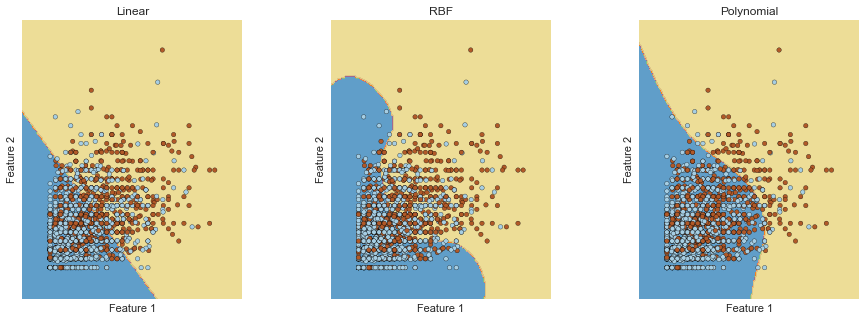

In [81]:
# Train SVC classifiers with columns 21 and 76
X_tr_transf_20_75 = X_tr_transf[:,[20,75]]
svc_lin_2 = SVC(kernel='linear').fit(X_tr_transf_20_75, y_tr)
svc_rbf_2 = SVC(kernel='rbf').fit(X_tr_transf_20_75, y_tr)
svc_poly_2 = SVC(kernel='poly').fit(X_tr_transf_20_75, y_tr)
# Plot decision boundaries
svc_classifiers = [svc_lin_2, svc_rbf_2, svc_poly_2]
show_svc_decision_boundaries(svc_classifiers, X_tr_transf_20_75, title=['Linear', 'RBF', 'Polynomial'])

*My answer:*

The above decision boundaries reflect the methods used to separate the data points. The linear kernel separates data using a straight line as boundary; the RBF kernel separates data as a function of the distance to a particular point; and the polynomial kernel uses a poly-feature space to decide on the boundary.

### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

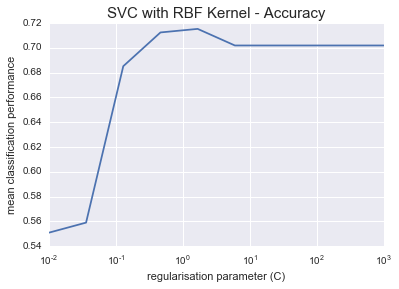

Optimal parameter of C: 1.6681005372
Classification accuracy on training set using optimal C: 0.974677496417
Classification accuracy on validation set using optimal C: 0.727762803235


In [89]:
# Estimate accuracy over log space in C
scores_2 = np.zeros((3,10))
logs_2 = np.logspace(-2, 3, 10)
f = 0
for train_indeces, test_indeces in kf3:
    log_set = 0
    for log in logs_2:
        svc_temp = SVC(kernel='rbf', gamma='auto', C=log)
        svc_temp.fit(X_tr_transf[train_indeces], y_tr[train_indeces])
        pred = svc_temp.predict(X_tr_transf[test_indeces])
        scores_2[f][log_set] = accuracy_score(y_tr[test_indeces], pred)
        log_set += 1
    f+= 1

# Get mean scores
mean_scores_2 = np.zeros(len(scores_2[0]))
for i in range(0, len(scores_2[0])):
    sum = 0.0
    count = 0
    for fold_scores in scores_2:
        sum += fold_scores[i]
        count += 1
    mean_scores_2[i] = sum/count

# Plot accuracy over different C values
plt.plot(logs_2, mean_scores_2)
plt.xscale('log')
plt.xlim(10**(-2), 10**3)
plt.xlabel('regularisation parameter (C)')
plt.ylabel('mean classification performance')
plt.title('SVC with RBF Kernel - Accuracy', fontsize=15)
plt.show()

# Get optimal C
optimal_C_2 = logs_2[np.argmax(mean_scores_2)]
print("Optimal parameter of C: {0}".format(optimal_C_2))
# Get accuracy with optimal parameter
svc_rbf_3 = SVC(kernel='rbf', gamma='auto', C=optimal_C_2)
svc_rbf_3.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set using optimal C: {0}'.format(svc_rbf_3.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set using optimal C: {0}'.format(svc_rbf_3.score(X_val_transf, y_val)))

### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

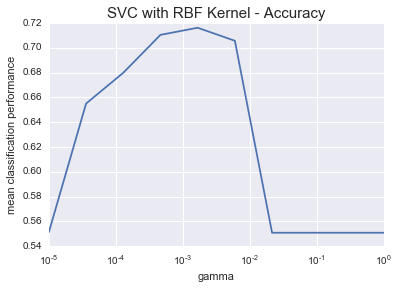

Optimal gamma: 0.0016681005372
Classification accuracy on training set using optimal gamma: 0.891065456283
Classification accuracy on validation set using optimal gamma: 0.726864330638


In [90]:
# Estimate accuracy over log space in gamma
scores_3 = np.zeros((3,10))
logs_3 = np.logspace(-5, 0, 10)
f = 0
for train_indeces, test_indeces in kf3:
    log_set = 0
    for log in logs_3:
        svc_temp = SVC(kernel='rbf', gamma=log, C=1.0)
        svc_temp.fit(X_tr_transf[train_indeces], y_tr[train_indeces])
        pred = svc_temp.predict(X_tr_transf[test_indeces])
        scores_3[f][log_set] = accuracy_score(y_tr[test_indeces], pred)
        log_set += 1
    f+= 1

# Get mean scores
mean_scores_3 = np.zeros(len(scores_3[0]))
for i in range(0, len(scores_3[0])):
    sum = 0.0
    count = 0
    for fold_scores in scores_3:
        sum += fold_scores[i]
        count += 1
    mean_scores_3[i] = sum/count

# Plot accuracy over different gamma values
plt.plot(logs_3, mean_scores_3)
plt.xscale('log')
plt.xlim(10**(-5), 10**0)
plt.xlabel('gamma')
plt.ylabel('mean classification performance')
plt.title('SVC with RBF Kernel - Accuracy', fontsize=15)
plt.show()

# Get optimal gamma
optimal_gamma = logs_3[np.argmax(mean_scores_3)]
print("Optimal gamma: {0}".format(optimal_gamma))
# Get accuracy with optimal parameter
svc_rbf_4 = SVC(kernel='rbf', gamma=optimal_gamma, C=1.0)
svc_rbf_4.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set using optimal gamma: {0}'.format(svc_rbf_4.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set using optimal gamma: {0}'.format(svc_rbf_4.score(X_val_transf, y_val)))

### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

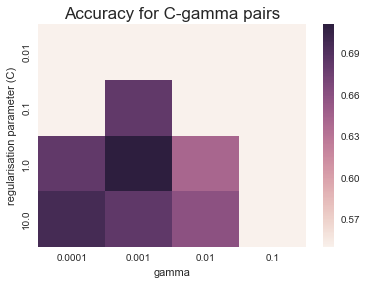

Optimal C: 1.0
Optimal gamma: 0.001
Classification accuracy on training set using optimal C and gamma: 0.834687052078
Classification accuracy on validation set using optimal C and gamma: 0.721473495058


In [94]:
# Estimate accuracy over log space in C and gamma
log_Cs = np.logspace(-2, 1, 4)
log_gs = np.logspace(-4, -1, 4)
scores_4 = np.zeros((4,4))
row = 0
for log_C in log_Cs:
    col = 0
    for log_g in log_gs:
        svc_temp = SVC(kernel='rbf', gamma=log_g, C=log_C)
        pred = cross_val_predict(estimator=svc_temp, X=X_tr_transf, y=y_tr)
        scores_4[row][col] = accuracy_score(y_tr, pred)
        col += 1
    row += 1

# Visualise heatmap of classification for C-gamma pairs
sns.heatmap(data=scores_4, xticklabels=log_gs, yticklabels=log_Cs)
plt.title('Accuracy for C-gamma pairs', fontsize=17)
plt.xlabel('gamma')
plt.ylabel('regularisation parameter (C)')
plt.show()

# Get optimal C-gamma pair
optimal_C_g = unravel_index(scores_4.argmax(), scores_4.shape)
optimal_C_3 = log_Cs[optimal_C_g[0]]
optimal_gamma_2 = log_gs[optimal_C_g[1]]
print('Optimal C: {0}'.format(optimal_C_3))
print('Optimal gamma: {0}'.format(optimal_gamma_2))
# Get accuracy with optimal parameters
svc_rbf_4 = SVC(kernel='rbf', gamma=optimal_gamma_2, C=optimal_C_3)
svc_rbf_4.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set using optimal C and gamma: {0}'.format(svc_rbf_4.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set using optimal C and gamma: {0}'.format(svc_rbf_4.score(X_val_transf, y_val)))

### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*

No it's not. We are only testing a limited range of C and gamma values. The performance could be further improved by trying out more values. The problem with this is that more values results in an exponentially more computationally expensive task.

etc. (actually no I don't think my suggested solution is a good one)

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

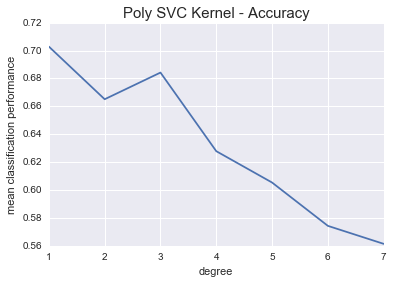

Optimal degree: 1
Classification accuracy on training set using optimal gamma: 0.891065456283
Classification accuracy on validation set using optimal gamma: 0.726864330638


In [109]:
# Estimate accuracy over log space in gamma
scores_4 = np.zeros((3,7))
degrees = np.arange(1,8)
f = 0
for train_indeces, test_indeces in kf3:
    degree_set = 0
    for degree in degrees:
        svc_temp = SVC(kernel='poly', degree=degree)
        svc_temp.fit(X_tr_transf[train_indeces], y_tr[train_indeces])
        pred = svc_temp.predict(X_tr_transf[test_indeces])
        scores_4[f][degree_set] = accuracy_score(y_tr[test_indeces], pred)
        degree_set += 1
    f+= 1

# Get mean scores
mean_scores_4 = np.zeros(len(scores_4[0]))
for i in range(0, len(scores_4[0])):
    sum = 0.0
    count = 0
    for fold_scores in scores_4:
        sum += fold_scores[i]
        count += 1
    mean_scores_4[i] = sum/count
    
# Plot accuracy over different degree values
plt.plot(degrees, mean_scores_4)
#plt.xscale('degree')
#plt.xlim(10**(-5), 10**0)
plt.xlabel('degree')
plt.ylabel('mean classification performance')
plt.title('Poly SVC Kernel - Accuracy', fontsize=15)
plt.show()

# Get optimal degree
optimal_degree = degrees[np.argmax(mean_scores_4)]
print("Optimal degree: {0}".format(optimal_degree))
# Get accuracy with optimal parameter
svc_rbf_4 = SVC(kernel='rbf', gamma=optimal_gamma, C=1.0)
svc_rbf_4.fit(X_tr_transf, y_tr)
print('Classification accuracy on training set using optimal gamma: {0}'.format(svc_rbf_4.score(X_tr_transf, y_tr)))
print('Classification accuracy on validation set using optimal gamma: {0}'.format(svc_rbf_4.score(X_val_transf, y_val)))

### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*

bladiblabdibla

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [89]:
# Retrieve features and targets
X_tr_2 = train_A.drop(['imgId', 'is_person'], axis=1)
X_val_2 = valid_A.drop(['imgId', 'is_person'], axis=1)
y_tr_2 = train_A['is_person']
y_val_2 = valid_A['is_person']

# Standardise features
stand_scaler_2 = StandardScaler()
stand_scaler_2.fit(X_tr_2)
X_tr_2_transf = stand_scaler_2.transform(X_tr_2)
X_val_2_transf = stand_scaler_2.transform(X_val_2)

# Train Random Forest Classifier and report accuracy
rf_2 = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=31)
rf_2.fit(X_tr_2_transf, y_tr_2)
print('Classification accuracy on training set: {0}'.format(rf_2.score(X_tr_2_transf, y_tr_2)))
print('Classification accuracy on validation set: {0}'.format(rf_2.score(X_val_2_transf, y_val_2)))

# Display 50 most important features
features_2 = pd.DataFrame(columns = ['Feature', 'Importance'], data = np.array([X_tr_2.columns.tolist(), rf_2.feature_importances_]).T)
features_2.sort_values(by='Importance', ascending=False, inplace=True)
print(features_2.head(50)['Feature'].tolist())

Classification accuracy on training set: 1.0
Classification accuracy on validation set: 0.711590296496
['is_diningtable', 'is_boat', 'is_bus', 'dim63', 'is_sofa', 'is_sheep', 'is_cat', 'is_bird', 'dim21', 'dim51', 'dim360', 'dim4', 'dim76', 'dim398', 'dim283', 'dim479', 'dim263', 'dim343', 'dim423', 'dim485', 'dim254', 'dim461', 'dim222', 'dim356', 'dim74', 'dim288', 'dim214', 'dim348', 'dim330', 'dim217', 'dim483', 'dim90', 'dim274', 'dim347', 'dim17', 'dim427', 'dim35', 'dim326', 'dim73', 'dim312', 'dim48', 'dim25', 'dim315', 'dim322', 'dim329', 'dim500', 'dim134', 'dim206', 'is_aeroplane', 'dim96']


*Your answer goes here*



## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*My answer:*

### Exploring the dataset ###

Let's load the data.

In [3]:
# Load the datasets
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path, delimiter = ',')

# Retrieve names of attributes of interest
attributes = train_B.columns[1:501].tolist()

First, we need to get a basic overview of our data.

In [4]:
train_B.describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,...,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,0.043353,0.050830,0.047988,0.037411,0.043365,0.049670,0.051071,0.043601,0.052698,0.054139,...,0.017511,0.025083,0.088027,0.045433,0.048273,0.448178,0.040227,0.015144,0.032655,0.050639
std,0.513260,0.582839,0.482166,0.464611,0.491187,0.558422,0.577599,0.472706,0.571629,0.588484,...,0.131195,0.156414,0.283401,0.208301,0.214392,0.497425,0.196538,0.122156,0.177774,0.219311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000868,0.000000,0.001359,0.000781,0.001116,0.001019,0.000340,0.000651,0.000756,0.001116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001616,0.000340,0.003516,0.001698,0.002038,0.001860,0.000756,0.001645,0.001698,0.002155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.002404,0.001008,0.006454,0.002717,0.003125,0.003057,0.001488,0.003397,0.002734,0.003736,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,9.984000,9.122238,7.676800,9.695738,8.762671,9.489078,9.751526,8.691076,9.013933,9.602705,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It's always important to check for outliers before training a model. In this case, the attributes (dim1, dim2, ...) represent SIFT features. Since these can only take a value between 0 and 1, there are clearly some outliers in our dataset. Let's remove them.

### Making some changes ###

In [5]:
# Remove outliers
outlier_rows = []
for col in attributes:
    col_items = train_B[col]
    to_remove = col_items.loc[col_items > 1].index # threshold at 1
    outlier_rows.extend(to_remove)
train_B.drop(outlier_rows, axis=0, inplace=True)
train_B.describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
count,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,...,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000
mean,0.001751,0.000756,0.004317,0.001853,0.002272,0.002220,0.001019,0.002446,0.002088,0.002746,...,0.017200,0.025323,0.088390,0.045867,0.048256,0.449116,0.040134,0.015289,0.032489,0.050167
std,0.001193,0.001406,0.003693,0.001340,0.001598,0.001741,0.000873,0.002910,0.001971,0.002328,...,0.130048,0.157140,0.283929,0.209247,0.214358,0.497523,0.196320,0.122729,0.177338,0.218342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000833,0.000000,0.001359,0.000756,0.001116,0.001019,0.000340,0.000625,0.000744,0.001116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001563,0.000340,0.003397,0.001698,0.002038,0.001860,0.000744,0.001563,0.001698,0.002056,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.002378,0.000893,0.006324,0.002717,0.003057,0.003057,0.001488,0.003397,0.002717,0.003736,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.009851,0.016644,0.027514,0.010789,0.010417,0.021739,0.005774,0.029830,0.028372,0.020380,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


That looks better. Let's prepare our datasets.

In [6]:
# (Re-)Prepare data
X_train = train_B[attributes]
X_valid = valid_B[attributes]
y_train = train_B['is_person']
y_valid = valid_B['is_person']

In [7]:
# Standardise training and validation features
stand_scaler = StandardScaler()
stand_scaler.fit(X_train)
X_train = pd.DataFrame(data=stand_scaler.transform(X_train), columns=attributes)
X_valid = pd.DataFrame(data=stand_scaler.transform(X_valid), columns=attributes)
# Show means and standard deviations
X_train.describe()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim491,dim492,dim493,dim494,dim495,dim496,dim497,dim498,dim499,dim500
count,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,...,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03,2.093000e+03
mean,2.206654e-17,2.208246e-16,2.682995e-16,1.608312e-16,-2.693338e-17,2.251742e-17,2.257577e-16,1.078662e-16,-4.296942e-17,-6.646486e-17,...,-3.607031e-18,-9.807943e-17,2.330779e-16,-2.851677e-16,7.198149e-17,2.758318e-18,3.522160e-17,-8.062776e-18,-2.229994e-16,5.803077e-17
std,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,...,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00,1.000239e+00
min,-1.467609e+00,-5.376270e-01,-1.169096e+00,-1.382494e+00,-1.422313e+00,-1.275367e+00,-1.166647e+00,-8.406811e-01,-1.059640e+00,-1.179971e+00,...,-1.320488e+00,-4.686334e-01,-7.874811e-01,-1.293148e+00,-1.370910e+00,-1.322547e+00,-9.000586e-01,-1.532385e+00,-1.244493e+00,-1.077284e+00
25%,-7.692574e-01,-5.376270e-01,-8.010576e-01,-8.183874e-01,-7.238232e-01,-6.900673e-01,-7.771932e-01,-6.258517e-01,-6.820925e-01,-7.004506e-01,...,-6.898876e-01,-4.686334e-01,-6.708815e-01,-7.231761e-01,-7.316762e-01,-7.098779e-01,-6.713329e-01,-7.453807e-01,-7.341369e-01,-7.086063e-01
50%,-1.572570e-01,-2.958123e-01,-2.491360e-01,-1.154922e-01,-1.467552e-01,-2.070083e-01,-3.144307e-01,-3.034357e-01,-1.979796e-01,-2.965535e-01,...,-1.694410e-01,-4.686334e-01,-3.209111e-01,-1.523642e-01,-2.200633e-01,-2.042302e-01,-2.996535e-01,-9.518560e-02,-2.237804e-01,-2.697382e-01
75%,5.260038e-01,9.749214e-02,5.435405e-01,6.448584e-01,4.910240e-01,4.805323e-01,5.377856e-01,3.269599e-01,3.191180e-01,4.253053e-01,...,5.211872e-01,9.607228e-02,3.208157e-01,5.804575e-01,4.391231e-01,5.154609e-01,2.620157e-01,5.662927e-01,4.568617e-01,3.974282e-01
max,6.791044e+00,1.129991e+01,6.282117e+00,6.667969e+00,5.097554e+00,1.121122e+01,5.447193e+00,9.412699e+00,1.333790e+01,7.576863e+00,...,5.406330e+00,1.761110e+01,8.370306e+00,7.297570e+00,7.836241e+00,5.723451e+00,7.746327e+00,4.456180e+00,6.022201e+00,9.246066e+00


We're going to be trying out and printing the results of several classifiers, so let's define a function that does some of the work for us, saving us time and effort in the future:

In [8]:
def calc_accuracy_and_logloss(estimator, X_train, y_train, X_valid, y_valid, description=None):
    """Calculates, displays and returns accuracy and log_loss for the given estimator"""
    estimator.fit(X_train, y_train)
    y_valid_pred = estimator.predict(X_valid)
    accuracy, logloss = estimator.score(X_valid, y_valid), log_loss(y_true=y_valid, y_pred=y_valid_pred)
    if description:
        print('Accuracy of {0}: {1}'.format(description, accuracy))
        print('Log loss of {0}: {1}'.format(description, logloss))
    return [accuracy, logloss]

### Let's do this! ###

Support Vector Classifiers are generally considered ideal for image classification tasks. Indeed, we saw that - in the tests in the first part of this assignment - we got the highest accuracy with an SVM classifier. Therefore, there is a good chance that we may see similar results for our new dataset. Before trying out SVCs, let's first calculate some scores using other classifiers, so that we can use them as a point of reference later on.

#### Logistic regressors

C:\Program Files\Anaconda2\envs\iaml\lib\site-packages\sklearn\linear_model\sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


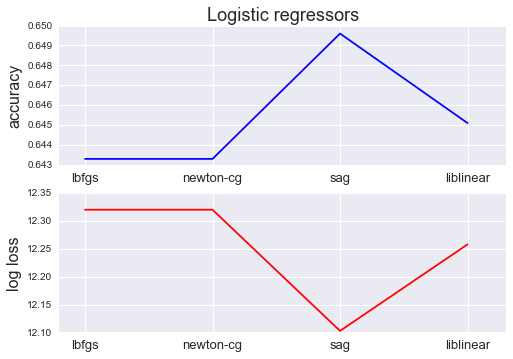

In [9]:
# Try out different logistic regressors
solver_list = ['lbfgs', 'newton-cg', 'sag', 'liblinear']
accuracies = []
loglosses = []
for s in solver_list:
    lr_temp = LogisticRegression(solver=s)
    acc, logl = calc_accuracy_and_logloss(lr_temp, X_train, y_train, X_valid, y_valid)
    accuracies.append(acc)
    loglosses.append(logl)

# Plot accuracy
plt.subplot(2,1,1)
plt1 = plt.plot(accuracies, c='b')
plt.title('Logistic regressors', fontsize=18)
plt.xlim(-0.2, 3.3)
plt.xticks(range(len(solver_list)), solver_list, fontsize=13)
plt.ylabel('accuracy', fontsize=16)
# Plot log loss
plt.subplot(2,1,2)
plt2 = plt.plot(loglosses, c='r')
plt.xlim(-0.2, 3.3)
plt.xticks(range(len(solver_list)), solver_list, fontsize=13)
plt.ylabel('log loss', fontsize=16)
plt.show()

In [10]:
# Print accuracy of most optimal logistic regressor
optimal_solver = solver_list[np.argmin(loglosses)]
lr_optimal = LogisticRegression(solver=optimal_solver)
description = 'optimal linear regressor ({0})'.format(optimal_solver)
lr_acc, lr_log = calc_accuracy_and_logloss(lr_optimal, X_train, y_train, X_valid, y_valid, description)

Accuracy of optimal linear regressor (sag): 0.649595687332
Log loss of optimal linear regressor (sag): 12.1026662364


#### K-nearest neighbors classifiers

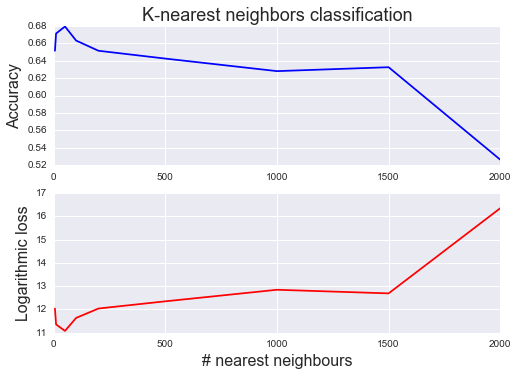

In [11]:
# Try out KNN with different k values
k_list = [5, 10, 50, 100, 200, 500, 1000, 1500, 2000]
accuracies = []
loglosses = []
for k in k_list:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    acc, logl = calc_accuracy_and_logloss(knn_temp, X_train, y_train, X_valid, y_valid)
    accuracies.append(acc)
    loglosses.append(logl)
# Plot results
plt.subplot(2,1,1)
plt.title('K-nearest neighbors classification', fontsize=18)
plt.plot(k_list, accuracies, c='b')
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(2,1,2)
plt.plot(k_list, loglosses, c='r')
plt.xlabel('# nearest neighbours', fontsize=16)
plt.ylabel('Logarithmic loss', fontsize=16)
plt.show()

In [12]:
# Get optimal KNN classifier
optimal_k = k_list[np.argmin(loglosses)]
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
description = 'KNN classifier with optimal k={0}'.format(optimal_k)
knn_acc, knn_log = calc_accuracy_and_logloss(knn_optimal, X_train, y_train, X_valid, y_valid, description)

Accuracy of KNN classifier with optimal k=50: 0.679245283019
Log loss of KNN classifier with optimal k=50: 11.07864212


#### Tree classifiers

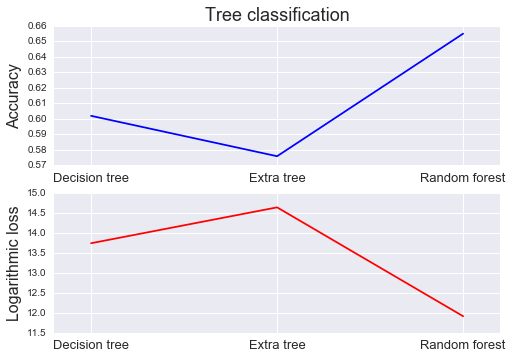

In [13]:
# Try out KNN with different k values
trees_list = [DecisionTreeClassifier(), ExtraTreeClassifier(), RandomForestClassifier()]
trees_labels = ['Decision tree', 'Extra tree', 'Random forest']
accuracies = []
loglosses = []
for tree in trees_list:
    acc, logl = calc_accuracy_and_logloss(tree, X_train, y_train, X_valid, y_valid)
    accuracies.append(acc)
    loglosses.append(logl)
# Plot results
plt.subplot(2,1,1)
plt.title('Tree classification', fontsize=18)
plt.plot(accuracies, c='b')
plt.xticks(range(len(trees_list)), trees_labels, fontsize=13)
plt.xlim(-0.2, 2.2)
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(2,1,2)
plt.plot(loglosses, c='r')
plt.xticks(range(len(trees_list)), trees_labels, fontsize=13)
plt.xlim(-0.2, 2.2)
plt.ylabel('Logarithmic loss', fontsize=16)
plt.show()

In [14]:
# Get optimal tree classifier
tr_optimal = trees_list[np.argmin(loglosses)]
description = 'optimal tree classifier ({0})'.format(trees_labels[np.argmin(loglosses)])
tr_acc, tr_log = calc_accuracy_and_logloss(tr_optimal, X_train, y_train, X_valid, y_valid, description)

Accuracy of optimal tree classifier (Random forest): 0.647798742138
Log loss of optimal tree classifier (Random forest): 12.1646881381


### Overview

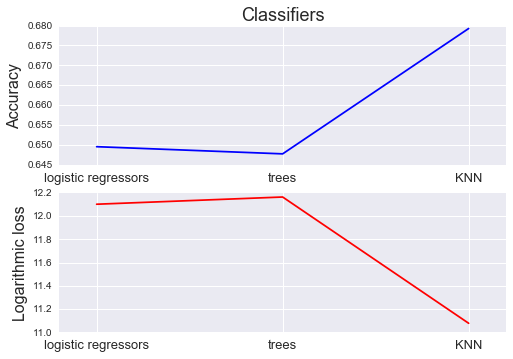

In [18]:
# Gather scores
basic_accuracies = [lr_acc, tr_acc, knn_acc]
basics_loglosses = [lr_log, tr_log, knn_log]
basic_labels = ['logistic regressors', 'trees', 'KNN']
# Plot scores
plt.subplot(2,1,1)
plt.title('Classifiers', fontsize=18)
plt.plot(basic_accuracies, c='b')
plt.xticks(range(len(basic_accuracies)), basic_labels, fontsize=13)
plt.xlim(-0.2, 2.2)
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(2,1,2)
plt.plot(basics_loglosses, c='r')
plt.xticks(range(len(basic_accuracies)), basic_labels, fontsize=13)
plt.xlim(-0.2, 2.2)
plt.ylabel('Logarithmic loss', fontsize=16)
plt.show()

It appears that the best classification method that we have tested so far is a K-Nearest Neighbors algorithm. It has a higher accuracy and lower logarithmic loss than the logistic regressors and trees that we tried out. It will be interesting to see how Support Vector Machine-methods compare.

### Support Vector Classifiers: RBF, linear and polynomial

SVCs make use of kernels, which can have a dramatic effect on the classification accuracy. Therefore, it is important to get a better idea of the distribution and values of the various features in our dataset.

For starters, let's visualise the relationship of attribute values to their respective target in our training data.

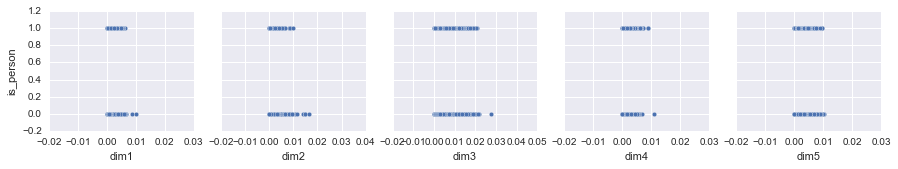

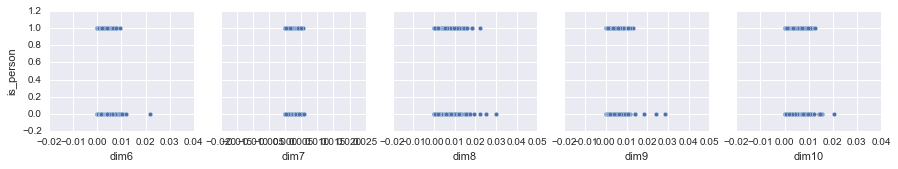

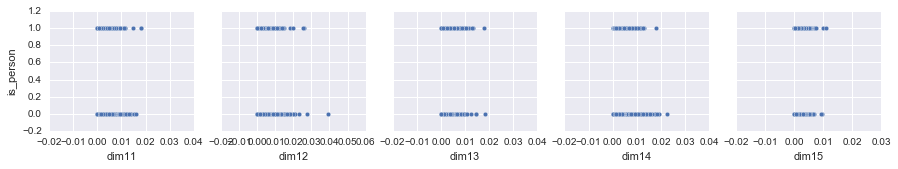

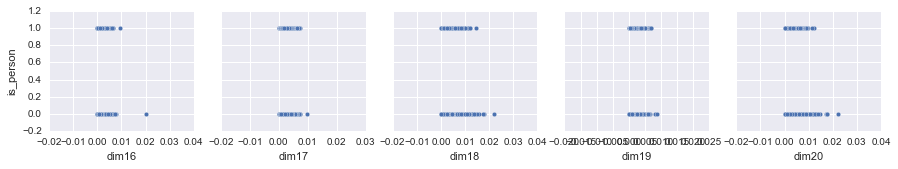

In [30]:
# Remove outliers
#for col in attributes:
#    col_items = train_B[col]
#    plt.

sns.pairplot(data=train_B, x_vars=attributes[0:5], y_vars=['is_person'])
sns.pairplot(data=train_B, x_vars=attributes[5:10], y_vars=['is_person'])
sns.pairplot(data=train_B, x_vars=attributes[10:15], y_vars=['is_person'])
sns.pairplot(data=train_B, x_vars=attributes[15:20], y_vars=['is_person'])


Blablabla

To get a better view of this, we can inspect the decision boundary of various SVC kernels between features. For this example, we select two attributes: dim21 and dim76 (because they are important features, as shown further below). 

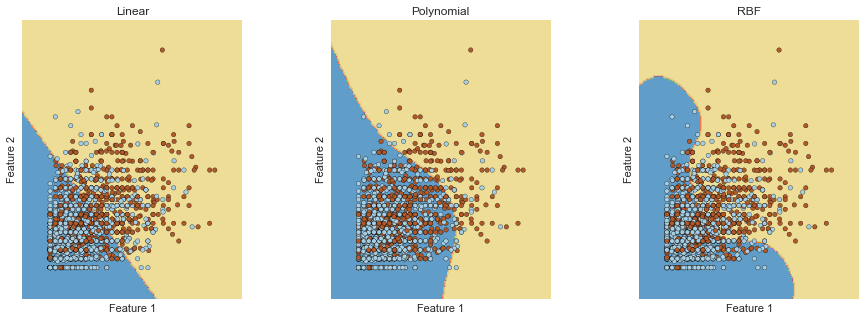

In [83]:
# Train SVC classifiers with dim21 and dim63
t_t = stand_scaler.transform(train_B[attributes])
X_train_21_76 = t_t[:,[20,75]]
svc_lin_temp = SVC(kernel='linear').fit(X_train_21_63, y_train)
svc_poly_temp = SVC(kernel='poly').fit(X_train_21_63, y_train)
svc_rbf_temp = SVC(kernel='rbf').fit(X_train_21_63, y_train)
# Plot decision boundaires
svc_classifiers_temp = [svc_lin_temp, svc_poly_temp, svc_rbf_temp]
show_svc_decision_boundaries(svc_classifiers_temp, X_train_21_63, \
                                     title=['Linear', 'Polynomial', 'RBF'])

As can be seen, there is no obvious decision boundary between the datapoints in this 2D space. As such, the linear kernel cannot properly separate the features. The polynomial kernel seems to be better, but still has many points on the wrong side of the decision boundary. The Radial Basis Function seems to do the best job at separating the data.

If these trends are reflective of the entire dataset, then we should expect a similar order in performance on the validation set (linear < polynomial < RBF).

In [84]:
# SVC with linear kernel (default settings)
svc_linear = SVC(kernel='linear')
description = 'SVC with linear kernel (default settings)'
svc_linear_acc, svc_linear_log = calc_accuracy_and_logloss(svc_linear, X_train, y_train, X_valid, y_valid, description)

Accuracy of SVC with linear kernel (default settings): 0.638814016173
Log loss of SVC with linear kernel (default settings): 12.4750641788


In [85]:
# SVC with polynomial kernel (default settings)
svc_poly = SVC(kernel='poly')
description = 'SVC with polynomial kernel (default settings)'
svc_poly_acc, svc_poly_log = calc_accuracy_and_logloss(svc_poly, X_train, y_train, X_valid, y_valid, description)

Accuracy of SVC with polynomial kernel (default settings): 0.701707097934
Log loss of SVC with polynomial kernel (default settings): 10.3027889465


In [86]:
# SVC with RBF kernel (default settings)
svc_rbf = SVC(kernel='rbf')
description = 'SVC with RBF kernel (default settings)'
svc_rbf_acc, svc_rbf_log = calc_accuracy_and_logloss(svc_rbf, X_train, y_train, X_valid, y_valid, description)

Accuracy of SVC with RBF kernel (default settings): 0.729559748428
Log loss of SVC with RBF kernel (default settings): 9.34076015037


As expected, the linear kernel performs the worst. The polynomial kernel does significantly better, and the RBF gives the best performance.

Overall, we now have:

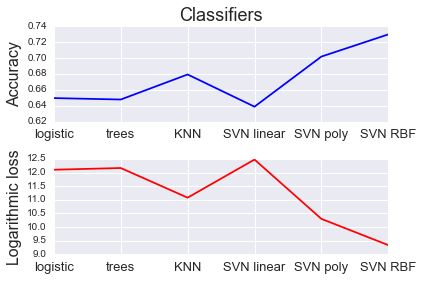

In [100]:
# Gather scores
basic_accuracies = [lr_acc, tr_acc, knn_acc, svc_linear_acc, svc_poly_acc, svc_rbf_acc]
basics_loglosses = [lr_log, tr_log, knn_log, svc_linear_log, svc_poly_log, svc_rbf_log]
basic_labels = ['logistic', 'trees', 'KNN', 'SVN linear', 'SVN poly', 'SVN RBF']
# Plot scores
plt.subplot(2,1,1)
plt.title('Classifiers', fontsize=18)
plt.plot(basic_accuracies, c='b')
plt.xticks(range(len(basic_accuracies)), basic_labels, fontsize=13)
#plt.xlim(-0.2, 2.2)
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(2,1,2)
plt.plot(basics_loglosses, c='r')
plt.xticks(range(len(basic_accuracies)), basic_labels, fontsize=13)
#plt.xlim(-0.2, 2.2)
plt.ylabel('Logarithmic loss', fontsize=16)
plt.tight_layout()
plt.show()

It seems that linear based classifiers (such as logistic regression and SVN linear) don't perform so well on our data, which makes sense if the decision boundary isn't linear. Trees don't seem able to distinguish the decision boundary either. Clearly, though, the Support Vector Machine classifier using the Radial Basis Function kernel gives the highest accuracy and lowest log loss on our validation data. Therefore, it makes sense to focus on it and try to optimise it using model engineering and feature engineering.

### Model parameter engineering

The most important parameters that we can tune for the SVC with RBF are the penalty parameter of the error term (C) and the kernel coefficient (gamma). Below, we compare the accuracy and log loss using various values for these parameters. 

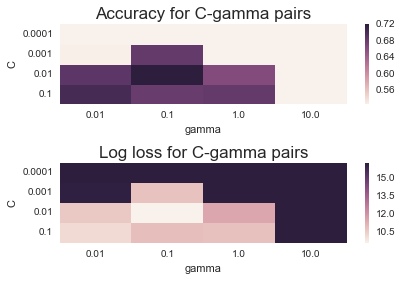

Accuracy of SVC RBF with optimal C and gamma: 0.721473495058
Log loss of SVC RBF with optimal C and gamma: 9.62005016578


[0.72147349505840075, 9.6200501657830237]

In [116]:
# Estimate accuracy over log space in C and gamma
Cs = np.logspace(-2, 1, 4)
gs = np.logspace(-4, -1, 4)
acc_scores = np.zeros((4,4))
log_scores = np.zeros((4,4))
row = 0
for c in Cs:
    col = 0
    for g in gs:
        svc_rbf_temp = SVC(kernel='rbf', gamma=g, C=c)
        acc_scores[row][col], log_scores[row][col] = \
            calc_accuracy_and_logloss(svc_rbf_temp, X_train, y_train, X_valid, y_valid)
        col += 1
    row += 1

# Visualise heatmap of accuracy for C-gamma pairs
plt.subplot(2,1,1)
sns.heatmap(data=acc_scores, xticklabels=Cs, yticklabels=gs)
plt.title('Accuracy for C-gamma pairs', fontsize=17)
plt.xlabel('gamma')
plt.ylabel('C')
# Visualise heatmap of accuracy for C-gamma pairs
plt.subplot(2,1,2)
sns.heatmap(data=log_scores, xticklabels=Cs, yticklabels=gs)
plt.title('Log loss for C-gamma pairs', fontsize=17)
plt.xlabel('gamma')
plt.ylabel('C')
plt.subplot(2,1,2)

plt.tight_layout()
plt.show()

# Get optimal C-gamma pair
optimal_C_g_indexes = unravel_index(log_scores.argmin(), log_scores.shape)
optimal_C = Cs[optimal_C_g_indexes[0]]
optimal_gamma = gs[optimal_C_g_indexes[1]]

# Get accuracy and log loss with optimal parameters
svc_rbf_temp = SVC(kernel='rbf', gamma=optimal_gamma, C=optimal_C)
calc_accuracy_and_logloss(svc_rbf_temp, X_train, y_train, X_valid, y_valid, 'SVC RBF with optimal C and gamma')

The optimal error term in this test is 1.0, while the "optimal" gamma actually performs worse than the default of sklearn's SVC (1/n_features). By now, we have noticed that our dataset is identical to the one in the first part of the assignment (after the outliers have been removed), in which we also tried model parameter engineering to no avail. Therefore, we should try to improve our performance using other techniques.

### Feature engineering

blabla

### Model combination

blabla

### SUBMITTING ###

In [105]:
# DONT FORGET TO STANDARDISE TESTING DATA (and maybe remove outliers)!

# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

NameError: name 'pred_proba' is not defined

*Your answer goes here*

